In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# 데이터 불러오기
df = pd.read_csv('../../Data1/kospi_data.csv')
print(df.dtypes)

Date       object
Close     float64
Open      float64
High      float64
Low       float64
Volume    float64
Change    float64
dtype: object


In [3]:
# Date 컬럼 Datetime으로 변경
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:,0:1]
print(X)
print(y)

               Open     High      Low       Volume  Change
Date                                                      
1981-05-01   123.60   123.60   123.60    3330000.0  0.0098
1981-05-02   123.50   123.50   123.50    2040000.0 -0.0008
1981-05-04   120.60   120.60   120.60    1930000.0 -0.0235
1981-05-06   120.70   120.70   120.70    1690000.0  0.0008
1981-05-07   119.30   119.30   119.30    1480000.0 -0.0116
...             ...      ...      ...          ...     ...
2022-08-25  2459.79  2477.26  2455.32  426230000.0  0.0122
2022-08-26  2489.14  2497.76  2476.75  520090000.0  0.0015
2022-08-29  2432.06  2432.89  2417.01  448750000.0 -0.0218
2022-08-30  2441.21  2453.91  2433.48     327210.0  0.0099
2022-08-31  2433.47  2473.75  2426.14     397290.0  0.0086

[11024 rows x 5 columns]
              Close
Date               
1981-05-01   123.60
1981-05-02   123.50
1981-05-04   120.60
1981-05-06   120.70
1981-05-07   119.30
...             ...
2022-08-25  2477.26
2022-08-26  2481.03
2022-08

In [6]:
train_len = int(len(df) * 0.7)

ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:train_len, :]
X_test = X_ss[train_len:, :]

y_train = y_ms[:train_len, :]
y_test = y_ms[train_len:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (7716, 5) (7716, 1)
Testing Shape (3308, 5) (3308, 1)


In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                   1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([7716, 1, 5]) torch.Size([7716, 1])
Testing Shape torch.Size([3308, 1, 5]) torch.Size([3308, 1])


In [8]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

batch = 256
seq_length = 7

# 텐서 형태로 데이터 정의
dataset = TensorDataset(X_train_tensors_f, y_train_tensors)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [9]:
# 설정값
data_dim = 5
hidden_dim = 10
output_dim = 1 
learning_rate = 0.0001
nb_epochs = 1000
layers = 4

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                             dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [10]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [130]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, layers).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.0836
Epoch: 0020 train loss : 0.0238
Epoch: 0040 train loss : 0.0132
Epoch: 0060 train loss : 0.0041
Epoch: 0080 train loss : 0.0019
Epoch: 0100 train loss : 0.0017
Epoch: 0120 train loss : 0.0013
Epoch: 0140 train loss : 0.0012
Epoch: 0160 train loss : 0.0011
Epoch: 0180 train loss : 0.0009
Epoch: 0200 train loss : 0.0007
Epoch: 0220 train loss : 0.0006
Epoch: 0240 train loss : 0.0005
Epoch: 0260 train loss : 0.0005
Epoch: 0280 train loss : 0.0005

 Early Stopping


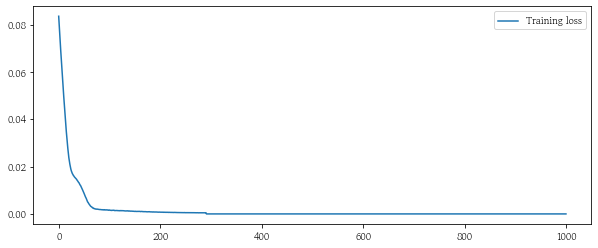

In [133]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [134]:
PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, layers).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(5, 10, num_layers=4, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [136]:
with torch.no_grad(): 
    pred = []
    for pr in range(len(X_train_tensors_f)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(X_train_tensors_f[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = ms.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = ms.inverse_transform(y_train_tensors)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(testY_inverse, pred_inverse))

MAE SCORE :  12.634246637066678


In [153]:
df_x_ss = ss.transform(data.iloc[:, 1:])
df_y_ms = ms.transform(data.iloc[:, :1])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

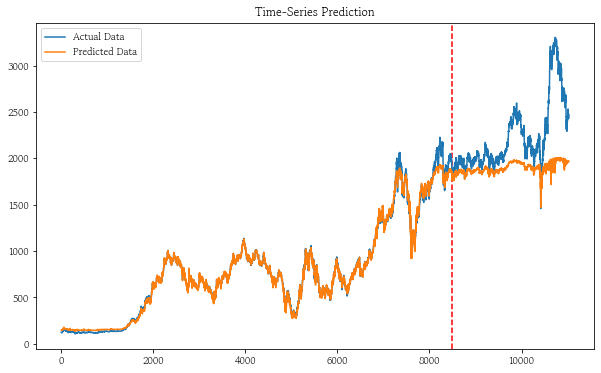

In [155]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize = (10, 6))
plt.axvline(x = 8500, c = 'r', linestyle = '--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [143]:
X

,Open,High,Low,Volume,Change
Date,,,,,
1981-05-01,123.60,123.60,123.60,3330000.0,0.0098
1981-05-02,123.50,123.50,123.50,2040000.0,-0.0008
1981-05-04,120.60,120.60,120.60,1930000.0,-0.0235
1981-05-06,120.70,120.70,120.70,1690000.0,0.0008
1981-05-07,119.30,119.30,119.30,1480000.0,-0.0116
...,...,...,...,...,...
2022-08-25,2459.79,2477.26,2455.32,426230000.0,0.0122
2022-08-26,2489.14,2497.76,2476.75,520090000.0,0.0015
2022-08-29,2432.06,2432.89,2417.01,448750000.0,-0.0218
